# 수학적 알고리즘 기말과제 (2)
## 201611523 안성빈 (통계학과)


## 과제의 목적
- 숫자 손글씨 데이터 MNIST를 분류하는 딥러닝 모델을 생성한다.
- CNN 기법을 사용한다.
- Train data 로 모델을 훈련하여 Test data 모델의 성능을 비교한다.
- 오차역전파에서 모멘텀을 사용한 경우와 SGD를 사용한 경우를 비교해본다.

# 0.library

In [139]:
import sys
import gzip
import shutil
import os
import matplotlib.pyplot as plt
import struct
import numpy as np
import pandas as pd
import pickle
from collections import OrderedDict
from sklearn.model_selection import train_test_split

# 1.MNIST데이터 불러오기
#### MNIST데이터는 숫자 손글씨를 28x28의 격자로 나눈 뒤 수치화한 데이터이다.
#### Data_size는 총 10000개이다



## 데이터 이미지 확인

행: 10000, 열: 784


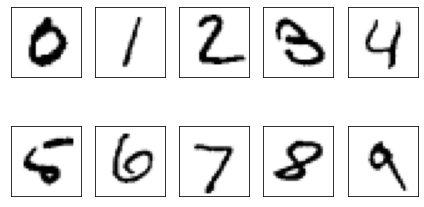

In [2]:
if(sys.version_info > (3,0)):
    writemode='wb'
else:
    writemode='w'

zipped_mnist=[f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z,mode='rb') as decompressed, open(z[:-3],writemode) as outfile:
        outfile.write(decompressed.read())

        
        
def load_mnist_image(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, 
                               '%s-labels.idx1-ubyte_' % kind)
    images_path = os.path.join(path, 
                               '%s-images.idx3-ubyte_' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = (images / 255.)  * 2
 
    return images, labels



X_data, y_data = load_mnist_image('', kind='t10k')
print('행: %d, 열: %d' % (X_data.shape[0], X_data.shape[1]))



fug,ax=plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(10):
    img=X_data[y_data==i][0].reshape(28,28)
    ax[i].imshow(img,cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### CNN을 하기 위해서 (1,28,28)형태로 데이터를 불러오는 함수를 생성
### 모델훈련을 위해 Target값을 One-Hot encoding 해주는 함수 생성

In [3]:
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, 
                               '%s-labels.idx1-ubyte_' % kind)
    images_path = os.path.join(path, 
                               '%s-images.idx3-ubyte_' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels),1, 28,28)
        
 
    return images, labels



def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T


X_data, y_data = load_mnist('', kind='t10k')
t_data=_change_one_hot_label(y_data)

In [4]:
X_data.shape

(10000, 1, 28, 28)

In [5]:
X_data[2]

array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,  38, 254, 109,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,  87, 252,  82,   0,   0,   0,   0,   0,
           0,   0,   0

# 2. 모델 훈련을 위해 필요한 Class 및 함수 생성

### 기존의 신경망에서 필요한 함수 및 class생성

In [7]:
# Relu class
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):      # Relu함수의 forward 학습을 위한 함수생성
        self.mask = (x <= 0)    
        out = x.copy()
        out[self.mask] = 0     # self.mask를 인덱스로 활용하여 음수인 경우 0으로 값 대체

        return out

    def backward(self, dout):  # Relu함수의 backward 학습을 위한 함수생성
        dout[self.mask] = 0    # forward 과정에서 음수였던 값들에 해당하는 인덱스(self.mask)의 업데이트는 0
        dx = dout              

        return dx

In [8]:
class Affine:                 # convolution 형태가 아닌 가중치 학습을 위한 class를 생성
    def __init__(self, W, b): # 모델의 성능향상을 위해서 편향도 고려한 모델을 생성한다.
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)            #데이터를 재배열해준다
        self.x = x

        out = np.dot(self.x, self.W) + self.b    # 가중치 곱

        return out

    def backward(self, dout):
        # 가중치 및 편향 업데이트를 위한 값들을 생성
        dx = np.dot(dout, self.W.T)              
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

In [9]:
def softmax(x):        # 소프트 맥스함수 생성
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):  # cross-entropy함수 생성
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    #원-핫 데이터를 정답 레이블로 전환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size




class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(One-Hot 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## 합성곱 층을 위한 class 및 함수 생성 
#### (이때 수업시간에 다루지 않은 패딩과 스트라이드라는 개념을 활용한다.)
- 패딩: 출력목적을 위해 입력 데이터 주변을 특정 값으로 채운다 (수업시간 기준 패딩=0)
- 스트라이드: 필터(Moving Window)를 적용하는 위치의 간격 (수업시간 기준 스트라이드=1)


### forward학습을 위해 이미지 -> 2차원 행렬로 전환해주는 im2col
### backward 학습을 위해 행렬 -> 이미지로 전환해주는 col2im  함수 생성

In [10]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.-> 역전파에 활용
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

### 합성곱을 위한 Convolution class생성
- 수업시간과 다르게 모델의 성능향상을 위해 편향을 포함한 모델생성

In [11]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape                          # 가중치의 shape저장
        N, C, H, W = x.shape                                  #  입력 데이터의 shape저장
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride) # 합성곱 이후의 data size
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride) # 합성곱 이후의 data size

        col = im2col(x, FH, FW, self.stride, self.pad)        #im2col로 데이터 전개
        col_W = self.W.reshape(FN, -1).T                      # 필터도 계산을 위해 reshape

        out = np.dot(col, col_W) + self.b                     # 가중치 곱 + 편향
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)  # resahpe을 통해 최종 합성곱데이터 생성

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape                          
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)        # 역전파를 위해 받아들이는 값을 연산을 위해 reshape한다
        
        # 가중치 및 편향을 업데이트하기 위한 값들을 받아준다.
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW) # 가중치의 형태에 맞게끔 변환

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)  # col2im을 통해 원래의 데이터 형태로 변환

        return dx


### pooling을 위한 class 생성

In [12]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):  # 해당 과제에서는 2,2로 pooling을 사용한다
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)  #pooling 이후의 data_size
        out_w = int(1 + (W - self.pool_w) / self.stride)  #pooling 이후의 data_size

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)  # 연산을 위해 im2col함수를 이용한 변환
        col = col.reshape(-1, self.pool_h*self.pool_w)               

        arg_max = np.argmax(col, axis=1)                                  # max값을 추출하는 pooling을 사용
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)       # reshape하여 데이터 형태를 적합시킴

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)                                
        
        pool_size = self.pool_h * self.pool_w                             # 역전파를 위한 pool_size생성
        dmax = np.zeros((dout.size, pool_size))                           # 받아주는 행렬 생성
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten() # 역전파위한 값 생성
        dmax = dmax.reshape(dout.shape + (pool_size,))                    # reshape을 통한 데이터 형태 변환
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

### 역전파에 사용할 SGD class와 Momentum class생성
- 학습률은 0.01로 설정

In [13]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

# 3.CNN 
## 앞서 생성한 class 와 함수를 이용하여 CNN을 구현한다

In [161]:
class CNN:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST -> 28x28）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트
    output_size : 출력 크기（MNIST -> 10）
    activation : 활성화 함수 - 'ReLU' 
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01） # 빠른 성능향상을 위한 정규화

    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':20, 'filter_size':9, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화  # 표준편차를 0.01로 하였다
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        # 각 layer를 계층식으로 OrderDict()에 차례로 추가하여사용한다
        # OrderDict() 는 순서가 있는 딕셔너리이다.
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss() # 마지막 SofrmaxWithLoss 계층은 따로 저장해둔다(계산 편리성 위해)

###########################################################################################################
########################################### Forward  ######################################################

    def predict(self, x):                 
        for layer in self.layers.values(): # layer에 추가한 순서대로 forward를 실행해 다음 계층에 전달
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수 
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):          # 정확도를 측정하는 함수 생성
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)                     # 정답이면 acc을 추가
        
        return acc / x.shape[0]                        # 최종 데이터 size로 나누어 정확도 측정

################################################################################################
######################################### Backward ##############################################

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # loss 값
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)    # 각 계층의 backward를 통한 값 추출

        layers = list(self.layers.values())      # 기울기의 값을 list로 저장
        layers.reverse()                         # 역전파(역순으로 진행)이기 때문에 역순으로 배열 
        
        for layer in layers:
            dout = layer.backward(dout)           

        # 가중치와 편향 각각 역전파 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        


# 4. 신경망 훈련을 해주는 클래스 Trainer 생성
### SGD와 Momentum 각각 10번 씩 총 20번의 train이 필요하여 class 를 생성

In [165]:
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
        Parameters
        ----------
        network : 훈련 모델
        x_train : 훈련시에 사용되는 train의 feature data
        t_train : 훈련시에 사용되는 정답(Target) data
        x_test  : 훈련한 모델로 예측을 진행할 test의 feature data
        t_test  : x_test의 결과와 비교할 실제 test의 정답data
        epochs  : 총 데이터를 활용한 반복 횟수
        mini_batch_size   : batch_size
        optimizer : 역전파(최적화)에 사용하는 방법론 -> SGD와 Mometum이 있다.
    """
    # 초기화
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer- SGD or 모멘텀 선택
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum}    
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size /mini_batch_size, 1)   # minibatch사이즈에 따른 훈련 반복수
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)  # bsize만큼 사용할 index 랜덤추출
        x_batch = self.x_train[batch_mask]                               # 해당 인덱스의 data추출
        t_batch = self.t_train[batch_mask]                               # 해당 인덱스의 data추출
        
        grads = self.network.gradient(x_batch, t_batch)                  # batch_data를 훈련하여 가중치 get
        self.optimizer.update(self.network.params, grads)                # 선택한 방법으로 역전파
                                                                         # 모멘텀 or SGD
        loss = self.network.loss(x_batch, t_batch)                       # train에 따른 loss
        self.train_loss_list.append(loss)                                # train의 경향을 보기위해 loss list생성
        if self.verbose: print("train loss:" + str(loss))                 
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1                                      # train의 epoch을 알기위해 epoch을 count
            
            x_train_sample, t_train_sample = self.x_train, self.t_train 
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                                                                               
            train_acc = self.network.accuracy(x_train_sample, t_train_sample) # train_acc 추출
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)    # test_acc  추출
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):                                       #train을 진행
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

# 5.훈련을 통한 SGD 와 Momentum의 비교

### 훈련전에 데이터를 train과 test로 분리
- sklearn의 train_test_split 함수를 사용

In [166]:
x_train,x_test,t_train,t_test=train_test_split(X_data,t_data,test_size=0.2,shuffle=True)
print("x_train.shape:",x_train.shape)
print("x_test.shape:",x_test.shape)
print("t_train.shape:",t_train.shape)
print("t_test.shape:",t_test.shape)

x_train.shape: (8000, 1, 28, 28)
x_test.shape: (2000, 1, 28, 28)
t_train.shape: (8000, 10)
t_test.shape: (2000, 10)


### SGD를 활용한 train

In [167]:
max_epochs = 10

network = CNN(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 20, 'filter_size': 9, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

SGD_train_acc=trainer.train_acc_list
SGD_test_acc=trainer.test_acc_list

train loss:2.2711148347121686
=== epoch:1, train acc:0.165, test acc:0.141 ===
train loss:2.2173345693276088
train loss:2.206564492807784
train loss:2.2007742806066353
train loss:2.171185598877772
train loss:2.1663306827428115
train loss:2.1803098941331376
train loss:2.1668538769422923
train loss:2.1237238196448938
train loss:2.0120952930479787
train loss:2.112880797012223
train loss:1.9970524689408236
train loss:2.017669479094069
train loss:1.8846590738959401
train loss:1.9038665744192493
train loss:1.8891925165879864
train loss:1.7793646764983004
train loss:1.7891977411781148
train loss:1.7841102927351742
train loss:1.7108322982112885
train loss:1.6717025105614578
train loss:1.6372920323605769
train loss:1.6795123641000012
train loss:1.6022587529451722
train loss:1.5685294994221732
train loss:1.514360313190589
train loss:1.4318529299826972
train loss:1.366767383433854
train loss:1.240025329114733
train loss:1.2314084825015248
train loss:1.203466150043496
train loss:1.1010455987971133

train loss:0.22819547349601488
train loss:0.21941101715835462
train loss:0.2114316877202611
train loss:0.17426398156164782
train loss:0.2671420763110114
train loss:0.13367274535867096
train loss:0.30184062564217196
train loss:0.3203062570696704
train loss:0.2663100099261822
train loss:0.23137744158733597
train loss:0.22501383931536065
train loss:0.1918533166947138
train loss:0.19406380424330533
train loss:0.28008308720077346
train loss:0.17039679258793272
train loss:0.19513327206475772
train loss:0.17831260015381545
train loss:0.14916448997927992
train loss:0.21755554915626782
train loss:0.20714084116164105
train loss:0.11075305235533961
train loss:0.21135681547637353
train loss:0.15383297426532513
train loss:0.23564339032911
train loss:0.178501660348971
train loss:0.2060019681371282
train loss:0.15967360826303595
train loss:0.20453957073435736
train loss:0.12150154089572855
train loss:0.14256533507069757
train loss:0.08591251034077653
train loss:0.22372313851813697
train loss:0.135090

train loss:0.09038383289277416
train loss:0.14204442072762885
train loss:0.1520528992143977
train loss:0.08473790774988935
train loss:0.10532595713639345
train loss:0.25207348240407085
train loss:0.09569410464220071
train loss:0.06606086135755401
train loss:0.13666978590151854
train loss:0.1256602865870244
train loss:0.08268764052355007
train loss:0.11779336261439574
train loss:0.09653859044168805
train loss:0.10601042919371687
train loss:0.13980008171492359
train loss:0.06987229313518269
train loss:0.12207525630250216
train loss:0.09084419416644246
train loss:0.13973007384852135
train loss:0.13627921280845767
train loss:0.0923378378287853
train loss:0.06508514081695085
train loss:0.05054364865189607
train loss:0.1371038649254305
train loss:0.06561500681564712
train loss:0.14877089488414838
train loss:0.18476607513044432
train loss:0.18942523896447894
train loss:0.124633246479888
train loss:0.0919266087793762
train loss:0.05273637721160352
train loss:0.09612855347942663
train loss:0.12

train loss:0.11188507658620558
train loss:0.12155505461696176
train loss:0.04396160056628098
train loss:0.022098407096092374
train loss:0.051976225130610294
train loss:0.07195421292869844
train loss:0.07819582241438759
train loss:0.14431036700829172
train loss:0.06783310600168596
train loss:0.03996506019087844
train loss:0.07171533556090948
=============== Final Test Accuracy ===============
test acc:0.961


### Momentum을 활용한 train

In [168]:
max_epochs = 10

network = CNN(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 20, 'filter_size': 9, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

MMT_train_acc=trainer.train_acc_list
MMT_test_acc=trainer.test_acc_list

train loss:2.2939692321075547
=== epoch:1, train acc:0.146, test acc:0.142 ===
train loss:2.231078793287649
train loss:2.1950729801921254
train loss:2.1314569129600143
train loss:2.0825821425887945
train loss:1.9898483437594177
train loss:1.8423504390720453
train loss:1.7203951917156461
train loss:1.6207334915822824
train loss:1.370470944244701
train loss:1.0636116272866747
train loss:0.9801939643520607
train loss:0.8393636431839309
train loss:0.6906899221530084
train loss:0.555797853787717
train loss:0.5689694700344713
train loss:0.5258731051822114
train loss:0.5752195639329848
train loss:0.719943172437114
train loss:0.4173774693574292
train loss:0.745183678147799
train loss:0.6104409846934777
train loss:0.7039730245514925
train loss:0.4311215551282158
train loss:0.6698941244115649
train loss:0.41087298852373727
train loss:0.3487639984251303
train loss:0.4770399256369781
train loss:0.5661871977129045
train loss:0.548155044936001
train loss:0.285074221589173
train loss:0.40781224687528

train loss:0.02241218595691966
train loss:0.041147053696944706
train loss:0.03877151965991092
train loss:0.0424133793046013
train loss:0.03972314723867331
train loss:0.029579786212771728
train loss:0.013783714928711248
train loss:0.031091596977180006
train loss:0.052605218187982444
train loss:0.02790358772409424
train loss:0.007091936051932166
train loss:0.02818788568694692
train loss:0.03459890456849169
train loss:0.06027836920550673
train loss:0.01514214250592815
train loss:0.04606420880558587
train loss:0.025466000048981693
train loss:0.1244614473899302
train loss:0.038600305026050385
train loss:0.0625882514213109
train loss:0.011786115956084597
train loss:0.01841843711215134
train loss:0.023144964647679275
train loss:0.020492839140400534
train loss:0.0435574083248457
train loss:0.008406330108570594
train loss:0.015356333660147256
train loss:0.010525284401915724
train loss:0.06482282033774459
train loss:0.030718116895894928
train loss:0.08920201642342013
train loss:0.040560805680265

train loss:0.0064706828420334535
train loss:0.01233182016368514
train loss:0.03444596942903201
train loss:0.0223416882578353
train loss:0.009598243810797725
train loss:0.014720613708564761
train loss:0.01372686747987093
train loss:0.006605395749254177
train loss:0.01997836275756359
train loss:0.021041650169047306
train loss:0.005790729507806006
train loss:0.008690602468190754
train loss:0.011318572459809521
train loss:0.009912141215888386
train loss:0.006979996566364711
train loss:0.00602793431392969
train loss:0.006108538805714021
train loss:0.01286862630969635
train loss:0.02431427975826219
train loss:0.01083860395148886
train loss:0.012982256270444019
train loss:0.010063048808143347
train loss:0.01612683302665208
train loss:0.007505455037663486
train loss:0.009703940067563827
train loss:0.004037131319338594
train loss:0.003359658224920635
train loss:0.009336037460395297
train loss:0.004626089586978497
train loss:0.018123695988531353
train loss:0.011515900749285357
train loss:0.03340

train loss:0.005136098620929412
train loss:0.0012109244281744255
train loss:0.002845790647563246
train loss:0.0026473840134086163
train loss:0.0036836364981065574
train loss:0.0021914814736713464
train loss:0.007198252651636706
train loss:0.004598251640821909
train loss:0.0017384176848750086
train loss:0.005700756636658688
train loss:0.010885462911530275
train loss:0.0038003534219396844
train loss:0.00039470649792940386
train loss:0.0007998927076913929
train loss:0.0004606887932140527
train loss:0.0015249256759311456
train loss:0.005025901166646292
train loss:0.0014804165236187935
train loss:0.004595773109585035
train loss:0.0015779698120828931
train loss:0.0066092124996622115
train loss:0.0008915092882222824
train loss:0.005852102998635659
train loss:0.00804492548134767
train loss:0.0031112412837908383
train loss:0.003726462656913327
train loss:0.0038249678363868646
train loss:0.0011438036457106762
train loss:0.0042970203670099575
train loss:0.0028721424664123973
=============== Final

### SGD와 Momentum의 train_acc비교

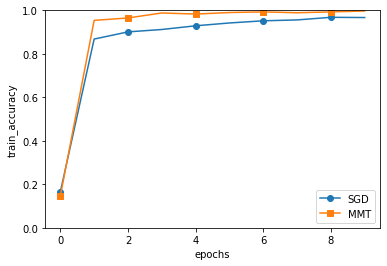

In [169]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, SGD_train_acc, marker='o', label='SGD', markevery=2)
plt.plot(x, MMT_train_acc, marker='s', label='MMT', markevery=2)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### SGD와 Momentum의 test_acc비교`

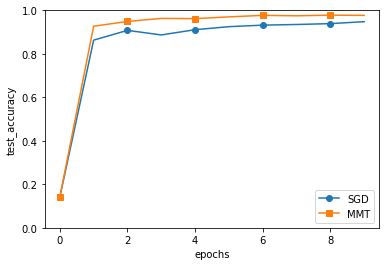

In [170]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, SGD_test_acc, marker='o', label='SGD', markevery=2)
plt.plot(x, MMT_test_acc, marker='s', label='MMT', markevery=2)
plt.xlabel("epochs")
plt.ylabel("test_accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## SGD보다 Momentum을 사용했을 때 정확도가 더 빠르게 상승함을 알 수 있다.

# 6. SGD와 Momentum의 10번 반복 및 정확도 그래프
- 계산 시간이 오래 걸리기에 epoch=5로 설정한다
- 시각화가 목적이므로 그래프를 위에 그리고 계산을 밑으로 내린다

### 반복하기 전 random 하게 train_test_data 를 10개 생성한다(random_state를 다르게 설정)

In [108]:
x_train_0,x_test_0,t_train_0,t_test_0=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=0)
x_train_1,x_test_1,t_train_1,t_test_1=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=1)
x_train_2,x_test_2,t_train_2,t_test_2=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=2)
x_train_3,x_test_3,t_train_3,t_test_3=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=3)
x_train_4,x_test_4,t_train_4,t_test_4=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=4)
x_train_5,x_test_5,t_train_5,t_test_5=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=5)
x_train_6,x_test_6,t_train_6,t_test_6=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=6)
x_train_7,x_test_7,t_train_7,t_test_7=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=7)
x_train_8,x_test_8,t_train_8,t_test_8=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=8)
x_train_9,x_test_9,t_train_9,t_test_9=train_test_split(X_data,t_data,test_size=0.2,shuffle=True,random_state=9)

<BarContainer object of 10 artists>

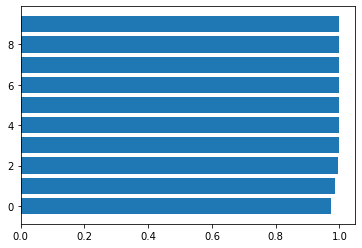

In [147]:
plt.barh(range(10),MMT_acc)

<BarContainer object of 10 artists>

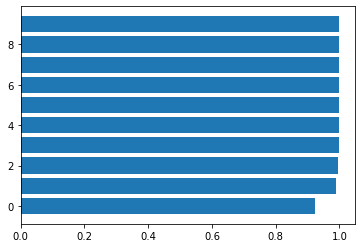

In [148]:
plt.barh(range(10),SGD_acc)

In [123]:
max_epochs = 5

network = CNN(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 20, 'filter_size': 9, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 정확도 받아줄 list생성
MMT_acc=[]
SGD_acc=[]

In [124]:
x_train=x_train_0
x_test = x_test_0
t_train=t_train_0
t_test = t_test_0

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:2.3123621794828697
=== epoch:1, train acc:0.081, test acc:0.096 ===
train loss:2.2626616335936505
train loss:2.2511257970383154
train loss:2.2566507369915443
train loss:2.229165795629021
train loss:2.1636582473441175
train loss:2.2431460767232836
train loss:2.2092921062901327
train loss:2.1835378017804055
train loss:2.167888166987102
train loss:2.181208763206406
train loss:2.1361410710081845
train loss:2.143502539913165
train loss:2.1035920047445438
train loss:2.1228886673767438
train loss:2.1154610947203087
train loss:2.023587621460314
train loss:1.9836121755728562
train loss:2.0145377183399895
train loss:1.9851781637225878
train loss:1.951300946447427
train loss:1.9572042707910222
train loss:1.8626737184569864
train loss:1.8828726548947228
train loss:1.7948407298175397
train loss:1.7602488028740615
train loss:1.8024847336476455
train loss:1.7586424722332143
train loss:1.6954636134500491
train loss:1.6066656648849262
train loss:1.5790393060585357
train loss:1.48353854269130

train loss:0.2923144498471644
train loss:0.18733852167183823
train loss:0.18215142055353875
train loss:0.35957013972358476
train loss:0.16566272420483177
train loss:0.23002051283621172
train loss:0.22382880284507933
train loss:0.19643703518953742
train loss:0.22795237533570537
train loss:0.1735182699249517
train loss:0.26866408047596735
train loss:0.10810147408744379
train loss:0.1710942259692412
train loss:0.18962389257013024
train loss:0.16182230388443994
train loss:0.18852883493080305
train loss:0.2458119512470201
train loss:0.27034153596281985
train loss:0.18413066258051247
train loss:0.18164090528707127
train loss:0.2105660984349665
train loss:0.18196795760518672
train loss:0.2709932390779511
train loss:0.14611122542683294
train loss:0.32963743936120626
train loss:0.23475492683548665
train loss:0.31210281836056974
train loss:0.18491373579910944
train loss:0.2342340900763287
train loss:0.13310351198715192
train loss:0.21043859153957553
train loss:0.27849470477870747
train loss:0.23

train loss:0.05515393837837572
train loss:0.05841915214795192
train loss:0.04845887834253415
train loss:0.07286975634188597
train loss:0.0877234042362657
train loss:0.11270830426686716
train loss:0.08825873066540799
train loss:0.051697182227123724
train loss:0.15789910235648658
train loss:0.055507523227509264
train loss:0.1087563652794169
train loss:0.08863385406192896
train loss:0.06924244178287715
train loss:0.07528583867113581
train loss:0.03331810473280005
train loss:0.03973630115118569
train loss:0.02041076489359404
train loss:0.056185614824086454
train loss:0.10127115892003592
train loss:0.12937108670901126
train loss:0.05473902549281512
train loss:0.081840172607551
train loss:0.07290520097482991
train loss:0.13493230101274786
train loss:0.04293817056374381
train loss:0.1240892207624786
train loss:0.04226177194706892
train loss:0.11044204075622405
train loss:0.06116722528754541
train loss:0.03736118033798532
train loss:0.08943062371338009
train loss:0.07230338135565155
train loss

train loss:0.02671825188704567
train loss:0.018881136858677986
train loss:0.005131040994195637
train loss:0.019869762737761608
train loss:0.007881083737345794
train loss:0.03695320723721357
train loss:0.04937050704862179
train loss:0.027433085968217596
train loss:0.02273877000172563
train loss:0.018376674098687536
train loss:0.015288488830326307
train loss:0.021486277045211298
train loss:0.03132373363339026
train loss:0.008872782847622395
train loss:0.020523804644408162
=============== Final Test Accuracy ===============
test acc:0.9755


In [125]:
x_train=x_train_1
x_test = x_test_1
t_train=t_train_1
t_test = t_test_1

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.019356740395505893
=== epoch:1, train acc:0.988, test acc:0.991 ===
train loss:0.012799358398021845
train loss:0.02752705616233291
train loss:0.03089538166989864
train loss:0.08779262170276345
train loss:0.01587871254043946
train loss:0.01686594977298102
train loss:0.006076779296157517
train loss:0.022059937180391655
train loss:0.009926258199984155
train loss:0.05541661878026672
train loss:0.014864517722029324
train loss:0.00619936583842807
train loss:0.00460483050222178
train loss:0.026806928320209162
train loss:0.005697096047862638
train loss:0.0021277531865246248
train loss:0.0026401878411610067
train loss:0.010050812219239895
train loss:0.010783733830749622
train loss:0.024913201626710423
train loss:0.032967919663749574
train loss:0.011925706171278276
train loss:0.006042208334841922
train loss:0.016329326659992635
train loss:0.007550822311372612
train loss:0.004811327700615689
train loss:0.022394456638523172
train loss:0.008112841732719245
train loss:0.0077038767511600

train loss:0.01127042259617999
train loss:0.011647075086212181
train loss:0.00834590011463012
train loss:0.010330990939130612
train loss:0.010763318579251797
train loss:0.0376163224147769
train loss:0.013958153705464544
train loss:0.012183839707128705
train loss:0.023896791865840154
train loss:0.0072802815188676715
train loss:0.0019780857683535324
train loss:0.0018129875448820235
train loss:0.01446399371560153
train loss:0.018357300977885873
train loss:0.011317775097537614
train loss:0.006065418580512798
train loss:0.013227648257735057
train loss:0.021916757317895722
train loss:0.009139137659453596
train loss:0.00777767989581716
train loss:0.02227217753545725
train loss:0.048824593490038655
train loss:0.01221090160597067
train loss:0.012018396059203502
train loss:0.033629131012605076
train loss:0.007271552908498157
train loss:0.004702902733369686
train loss:0.00615680648976121
train loss:0.005740161472357398
train loss:0.010496185637225772
train loss:0.01180743169670108
train loss:0.02

train loss:0.01247457345985515
train loss:0.0128037554498048
train loss:0.01863751474093305
train loss:0.01983891540074188
train loss:0.010269170515373151
train loss:0.01099082827986547
train loss:0.010212186753566914
train loss:0.011232406564924058
train loss:0.0035991981207621647
train loss:0.0022252997899599026
train loss:0.016832209283120438
train loss:0.006945660342017457
train loss:0.01183057496433662
train loss:0.008253388519261549
train loss:0.013283364933923791
train loss:0.006496186697522796
train loss:0.015321667054362227
train loss:0.028920605382733507
train loss:0.005362843025159824
train loss:0.014437097500656401
train loss:0.008776735423054205
train loss:0.01744117840847841
train loss:0.0035698862745510503
train loss:0.00651529951940782
train loss:0.002209034952952389
train loss:0.011545635858158676
train loss:0.009769442531333277
train loss:0.002396075372968019
train loss:0.0109114942713391
train loss:0.028701618653838433
train loss:0.009659786034274859
train loss:0.030

train loss:0.0014378138004152825
train loss:0.0015720650861626654
train loss:0.008963313263539344
train loss:0.0015778141817251532
train loss:0.01002820854632779
train loss:0.005737180994029405
train loss:0.005685617702714769
train loss:0.003985952388449806
train loss:0.003219376362359391
train loss:0.009348632905067093
train loss:0.001073544584546969
train loss:0.008055998052799057
train loss:0.02966966589028232
train loss:0.00781202821040106
train loss:0.004104551747987203
train loss:0.0037194434159519806
train loss:0.0035794237675820396
train loss:0.0059762548996112564
train loss:0.007306482813511716
train loss:0.006543120686325139
train loss:0.006257806646389823
train loss:0.004027595163933981
train loss:0.0007125104709765399
train loss:0.000884370588542105
train loss:0.0011470450510254523
train loss:0.007917051491105564
train loss:0.003380110516993608
train loss:0.011359039476662076
train loss:0.0029530463016597965
train loss:0.0017956655243230996
train loss:0.005964778379099557
t

In [126]:
x_train=x_train_2
x_test = x_test_2
t_train=t_train_2
t_test = t_test_2

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.005826673972004559
=== epoch:1, train acc:0.998, test acc:0.996 ===
train loss:0.00995993141771814
train loss:0.0054301741816742835
train loss:0.0036040382096343554
train loss:0.004592185995988287
train loss:0.002491066058770273
train loss:0.0026306141631222617
train loss:0.006185773086370485
train loss:0.021837501350643943
train loss:0.0022062504891996633
train loss:0.003861297574010483
train loss:0.0008931220018894659
train loss:0.0060655601579289965
train loss:0.0025316722622458015
train loss:0.0026728134652653423
train loss:0.0011743388069750298
train loss:0.009847087316520174
train loss:0.008747698292672797
train loss:0.004062110047644195
train loss:0.004434099561823576
train loss:0.000640709323435195
train loss:0.0035217564074054588
train loss:0.0043427308206641195
train loss:0.004523641083584531
train loss:0.011683850638468926
train loss:0.019325418500408195
train loss:0.008443860442529533
train loss:0.0024751296716762758
train loss:0.005981405941989894
train loss:0

train loss:0.0007883316737789023
train loss:0.0007061121037718614
train loss:0.002142470422782599
train loss:0.00026442757016688167
train loss:0.0017247311075274272
train loss:0.02363174514960801
train loss:0.006862977098271185
train loss:0.000520371005878151
train loss:0.0024499485185510744
train loss:0.0002709316520529678
train loss:0.023610406772581034
train loss:0.0009978780139808109
train loss:0.001687065118551975
train loss:0.000860536485569066
train loss:0.0008425320868179557
train loss:0.003077338072638011
train loss:0.0011297915178242138
train loss:0.0015298878749360892
train loss:0.0014477030911264552
train loss:0.002507399135985417
train loss:0.003354146631410631
train loss:0.002915818513297762
train loss:0.004708323925725291
train loss:0.0017895973256900311
train loss:0.004486745598217944
train loss:0.0020288855395295723
train loss:0.0016721689223116144
train loss:0.001178261467618276
train loss:0.0010679890002294684
train loss:0.006404325477894586
train loss:0.004241678570

train loss:0.0026811603223029523
train loss:0.0021250207591812552
train loss:0.007675525628433857
train loss:0.00124175032579256
train loss:0.004865325995789833
train loss:0.0013613442762058583
train loss:0.0005571828661281805
train loss:0.0029288923160667698
train loss:0.003141295346578484
train loss:0.001441151992659345
train loss:0.0033527242947338585
train loss:0.00402084392655094
train loss:0.0061889135100825195
train loss:0.0027779314907518658
train loss:0.007132254448041369
train loss:0.0006976705391349644
train loss:0.010458578764449606
train loss:0.0038024693830511942
train loss:0.007418506134440647
train loss:0.00607788918009958
train loss:0.007439125599325786
train loss:0.011683253014813258
train loss:0.003942925893214841
train loss:0.0030241323640199883
train loss:0.004336736962083794
train loss:0.001215702580334832
train loss:0.012958035733048648
train loss:0.003040958298350666
train loss:0.004842152225664013
train loss:0.0045245376613522684
train loss:0.003918534684779824

train loss:0.0002725684275484593
train loss:0.0025336282268978703
train loss:0.0009971197815129306
train loss:0.0006931797957169376
train loss:0.0008097726573169433
train loss:0.0009302761351078756
train loss:0.0006724425494923809
train loss:0.0007627179038241788
train loss:0.0011772897596870793
train loss:0.0036401070542921078
train loss:0.00012071235275611141
train loss:0.0005227305872280885
train loss:0.0009110837530266092
train loss:0.0020658775556137497
train loss:0.0013637887677465225
train loss:0.0006535083059190674
train loss:0.0004333061614776634
train loss:0.0005757786000365776
train loss:0.0003068501000865894
train loss:0.0011885118311420703
train loss:0.0005770451293192566
train loss:0.0005781974364878746
train loss:0.0004432606573830273
train loss:0.0011393364695879672
train loss:0.0011578983792052222
train loss:0.00206837577685978
train loss:0.0002414060492828251
train loss:0.00037015328526529383
train loss:0.0006210031545294671
train loss:0.0008019046160845561
train loss

In [127]:
x_train=x_train_3
x_test = x_test_3
t_train=t_train_3
t_test = t_test_3

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.0015405985439664771
=== epoch:1, train acc:0.999, test acc:0.999 ===
train loss:0.0010468446532341978
train loss:0.002436974911960187
train loss:0.0007205368296296801
train loss:0.0019705774283969627
train loss:0.0031206649642712627
train loss:0.001675199734711831
train loss:0.0014368409387167035
train loss:0.0010967576195788744
train loss:0.0014030830768365177
train loss:0.0014269863380260604
train loss:0.0013040457621750635
train loss:0.0006184026084092605
train loss:0.004330019474865012
train loss:0.0009162818571401817
train loss:0.0009505709158242134
train loss:0.0009712536580395181
train loss:0.0015597675886456078
train loss:0.0007669394154085237
train loss:0.00037313460172311676
train loss:0.004290285465580465
train loss:0.007468986949629797
train loss:0.0020800687117184364
train loss:0.00011941593061575833
train loss:0.00134952236670643
train loss:0.0028679833734993484
train loss:0.0039547045046988485
train loss:0.001187033896209667
train loss:0.0004361987851733864


train loss:0.0011533150955878664
train loss:0.000211407675938262
train loss:0.0005583309062854309
train loss:0.0010577909718436965
train loss:0.00047169399865582673
train loss:0.0010590935040603556
train loss:0.00045428223471949273
train loss:0.0005600457717967701
train loss:0.002481558196572155
train loss:0.0004321290719571387
train loss:0.0011709532805516823
train loss:0.0014246175015186365
train loss:0.000904869559757728
train loss:0.0011659661904765174
train loss:0.0005437987844238694
train loss:0.00026893504083706055
train loss:0.0008250638672344266
train loss:0.0009507235194868683
train loss:0.0005070563962126089
train loss:0.0021432833088360025
train loss:0.0008834396578634072
train loss:0.0008415731638853574
train loss:0.000966262270722307
train loss:0.0030450199820236585
train loss:0.0005770423024971897
train loss:0.000512115461210411
train loss:0.0019470199179996315
train loss:0.0008323935891056103
train loss:0.00024669740677017927
train loss:0.0028132148935524383
train loss:

train loss:0.0027917285670841867
train loss:0.00012369494429011134
train loss:0.0010041947040115725
train loss:0.0005353073612381426
train loss:0.000640977096882556
train loss:0.004092491480871007
train loss:0.0007553307902279783
train loss:0.0007190538435918317
train loss:0.0013024873132905018
train loss:0.0022763730459383403
train loss:0.0005871172754198146
train loss:0.0012809844833698355
train loss:0.0021114710874041744
train loss:0.002916280904548441
train loss:0.00419587719161147
train loss:0.0007900129854900037
train loss:0.0010406096427830278
train loss:0.0007968520933246552
train loss:0.00213966928848121
train loss:0.0003368563916691723
train loss:0.0007982564047784534
train loss:0.0008390420303932046
train loss:0.0027511392573131305
train loss:0.003922489553322302
train loss:0.0018181253402779405
train loss:0.0015878843454141074
train loss:0.0031015633702868154
train loss:0.0023614546873132764
train loss:0.0018643196166286964
train loss:0.003695941903996189
train loss:0.00148

train loss:0.0004554982385192357
train loss:0.0001789422106047255
train loss:0.0010497652223212142
train loss:0.00017087404928596166
train loss:0.0001529332333954272
train loss:0.0005144274706810478
train loss:0.0013983123793031007
train loss:0.0006297296828767
train loss:0.0014080953143022986
train loss:0.0003500909759587997
train loss:0.00018767555461606636
train loss:0.0004511272258811252
train loss:0.000455323866020734
train loss:0.0006278880052533373
train loss:0.0003520364788394658
train loss:0.0006525180713171251
train loss:0.0008586713532299352
train loss:5.90523770340935e-05
train loss:0.0006338614551524909
train loss:0.000654112193422269
train loss:0.0005123954556116798
train loss:0.0005281702918250384
train loss:0.0003922536339921271
train loss:0.0008110429858245818
train loss:0.00041800037190976034
train loss:0.0007236030456446621
train loss:0.0007909270228091167
train loss:0.0001106222536963359
train loss:0.0005021561403330875
train loss:0.0007529256358045222
train loss:0.

In [128]:
x_train=x_train_4
x_test = x_test_4
t_train=t_train_4
t_test = t_test_4

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.0002865001019853522
=== epoch:1, train acc:1.0, test acc:1.0 ===
train loss:0.0004078240868332423
train loss:0.0004490799659696619
train loss:0.0013827081944630946
train loss:0.0006158399470003996
train loss:0.0006582073450116921
train loss:0.0006888535840492888
train loss:9.066595012664693e-05
train loss:0.0006570149149199866
train loss:0.0016050344914998278
train loss:0.00039577314558228265
train loss:8.975544794200013e-05
train loss:0.00039195269020150927
train loss:0.0012393578087386695
train loss:0.0063649575308971
train loss:0.0009119819046198227
train loss:0.0010276373224154189
train loss:0.00012864798577408697
train loss:0.00042719255115484763
train loss:0.0009072920247126391
train loss:0.00046238903544253536
train loss:0.0013198162896033677
train loss:0.00039810615311112655
train loss:0.0010040558529587568
train loss:0.0002020045458012687
train loss:0.0005152727120041157
train loss:0.000369705567133538
train loss:0.001068293560292632
train loss:0.00051264469539154

train loss:0.00021291282748602452
train loss:0.001575090702866793
train loss:0.0003511616102508366
train loss:0.0007921707250449741
train loss:0.0005251665332484638
train loss:0.0003066674097107269
train loss:0.0010195409220154063
train loss:0.00046189520944921484
train loss:0.00021573450284063732
train loss:0.00016551117073630188
train loss:0.0001448871580671721
train loss:0.0005684826791596886
train loss:0.00029563296516316076
train loss:0.00015777980172184747
train loss:0.0003964363101685167
train loss:0.0007925862330574072
train loss:0.0003968731559688738
train loss:0.0005216699563403636
train loss:0.0013214560125534125
train loss:0.0002186893176638455
train loss:0.0002840174996005279
train loss:0.00014213295739202723
train loss:0.00032676903916011686
train loss:0.0014443147628930375
train loss:0.0007033481665656492
train loss:0.000460738232615399
train loss:0.00043182608135653334
train loss:0.00013676198770604797
train loss:0.0008025979767520604
train loss:0.000342574625685639
tra

train loss:0.0005159560949792199
train loss:0.00038481895364386634
train loss:0.00031559360308202824
train loss:0.0004381938495175517
train loss:0.0015820570072222892
train loss:0.002209438266084598
train loss:0.0010215828947764502
train loss:0.00048717948563812
train loss:0.0004235047558764953
train loss:0.0005917980363300572
train loss:0.001459587114779373
train loss:0.001387423857409422
train loss:0.0010926464754784952
train loss:0.0018693589819721067
train loss:0.0007822944661518309
train loss:0.000678657754316912
train loss:0.0013028798507286183
train loss:0.00040801353222033815
train loss:0.0003079699862375663
train loss:0.0006480035914392557
train loss:0.0004183055818330391
train loss:0.0009843969993316617
train loss:0.00026575648633353943
train loss:0.000302735871081047
train loss:0.000652205162003523
train loss:0.0003267938637388773
train loss:0.0026711670513136303
train loss:0.0009262628857309085
train loss:0.0003917687401054493
train loss:0.00024429183570054023
train loss:0.

train loss:0.00038084002382486886
train loss:0.0002977276329367647
train loss:0.000736686019696109
train loss:0.0004896088092603497
train loss:0.0005035089730005591
train loss:0.0002278197568890998
train loss:0.0007087659684182129
train loss:8.26365527689864e-05
train loss:0.0001300477103140747
train loss:0.0006661017208845643
train loss:0.00020431536248094635
train loss:0.0003534419479318843
train loss:0.00028404300889745904
train loss:0.00039847576630971964
train loss:0.0005646569511411875
train loss:0.0002897820356146474
train loss:0.00041492653640374876
train loss:0.00014233604456131014
train loss:0.0005206792799961988
train loss:0.00016139423919924085
train loss:0.0006010148705936241
train loss:0.00036854534054039917
train loss:0.0006789286029607832
train loss:0.00017835360846173596
train loss:0.0009447177711832097
train loss:0.0004840300082233863
train loss:0.00014148234599060426
train loss:0.00029449459622250547
train loss:0.0001806757069652829
train loss:0.00041294503907266
tra

In [129]:
x_train=x_train_5
x_test = x_test_5
t_train=t_train_5
t_test = t_test_5

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.000702329706777092
=== epoch:1, train acc:1.0, test acc:0.999 ===
train loss:0.00031871642717636495
train loss:0.0008916743167579253
train loss:0.00045896880953451383
train loss:0.0004473427670606809
train loss:0.0010119147406833131
train loss:0.00011632957320947518
train loss:0.0006840844988158245
train loss:0.0004223735308544933
train loss:0.00106274885119233
train loss:0.00011249094419162638
train loss:0.00034964641786740675
train loss:0.0004237264624667858
train loss:0.0002734964464147883
train loss:0.00035329212508928204
train loss:0.00016266677873754052
train loss:0.0008787508321191102
train loss:8.981843301357066e-05
train loss:0.0006505930081922746
train loss:0.0002393280300820992
train loss:0.0012734687883916443
train loss:0.0004458577202227229
train loss:0.00158161033501547
train loss:0.0004007586721777729
train loss:0.00045725301391437813
train loss:0.00025628007704045193
train loss:0.001821054235302977
train loss:8.103639051249635e-05
train loss:0.0004853911562

train loss:0.00019976297025808053
train loss:0.001221427921082663
train loss:0.0005903441348700467
train loss:0.0002917966903504916
train loss:0.00013471678629105457
train loss:0.00024135872331484487
train loss:0.0008296778545687146
train loss:0.00032936051118914045
train loss:0.0005638905169320451
train loss:0.00021227022768839597
train loss:0.0006133519855810954
train loss:0.0006686727565057046
train loss:0.0005483562574397741
train loss:0.0011148857496118866
train loss:7.716246457237321e-05
train loss:0.00041340661633620186
train loss:0.00016989925265461996
train loss:0.0008229582315388699
train loss:0.00032805010135023856
train loss:0.0005695240665988049
train loss:0.00014814536773738465
train loss:0.0002446879384205055
train loss:0.00039790815587302004
train loss:0.0007290294461401979
train loss:0.00013281948789250307
train loss:0.0005872186501495758
train loss:9.398146950738533e-05
train loss:0.001089819139136968
train loss:0.0003237008654371455
train loss:0.00017043195755511712


train loss:0.0002038446182381187
train loss:0.0004981278429009431
train loss:0.0001343097013002796
train loss:0.0003688596689617772
train loss:0.0004094061584738901
train loss:0.0002486198355199429
train loss:0.0004991144641726235
train loss:0.00036531346060285623
train loss:0.0002610563117432775
train loss:0.00039252364492473475
train loss:0.00024096906549552096
train loss:0.0005424116905883733
train loss:0.0004082998538040359
train loss:0.00032573787521135623
train loss:0.00019585406289126031
train loss:0.0004368849790305394
train loss:0.00021077434586270322
train loss:0.00044747805024133514
train loss:0.00034890956045041834
train loss:0.0012215496960657417
train loss:0.00014726829992278405
train loss:0.000547348220700525
train loss:0.00040922734485686487
train loss:0.0005113405756923691
train loss:0.00020941935433973328
train loss:7.894891770871977e-05
train loss:0.0003002860433667628
train loss:0.0003843170483612504
train loss:0.00014749759096217735
train loss:0.0004035561824351107

train loss:0.0002643935623257824
train loss:0.0002575896721918017
train loss:0.00021222256123063564
train loss:0.0002436823018523784
train loss:0.0001917361818997188
train loss:7.04040650445858e-05
train loss:0.00023494762421628887
train loss:0.00023483702679577754
train loss:0.00017892227351298917
train loss:0.0005415701700006304
train loss:0.00042152510165779656
train loss:4.344009231681047e-05
train loss:0.00026094902373632075
train loss:0.00024195081044971168
train loss:0.0006230616603048835
train loss:0.00021420376936554284
train loss:0.000326183622644753
train loss:0.0004987141491628055
train loss:0.00015925924501436085
train loss:0.00027932500264082677
train loss:0.00017109555523654477
train loss:0.0003584355668363768
train loss:0.00017155401438006987
train loss:5.7151322006281606e-05
train loss:0.00021234409192124598
train loss:4.358186560333479e-05
train loss:0.0001373636599090336
train loss:0.0001479037118517315
train loss:0.00021260056669718914
train loss:0.00029849046663106

In [130]:
x_train=x_train_6
x_test = x_test_6
t_train=t_train_6
t_test = t_test_6

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.00033845771638510436
=== epoch:1, train acc:1.0, test acc:1.0 ===
train loss:0.00010787364336635376
train loss:0.00021763279545613485
train loss:0.0003233013094770826
train loss:0.0005894550245377834
train loss:0.00028501474390179
train loss:0.00014084987315223562
train loss:0.00041617478912638924
train loss:0.000249346841514048
train loss:0.00036298319503112416
train loss:0.0002015992170231731
train loss:0.00020482063279430863
train loss:9.549901532123664e-05
train loss:5.0972446318914355e-05
train loss:9.947742590582112e-05
train loss:0.00019167556154751314
train loss:0.000320532861992187
train loss:0.00010669164540308351
train loss:0.00018861107886659887
train loss:0.00016675797777080764
train loss:0.00010086255118844266
train loss:0.00010213779972965122
train loss:0.00020104506966612124
train loss:0.00027949092639001567
train loss:0.00047397448408453716
train loss:0.001671912787249384
train loss:2.633553602055739e-05
train loss:0.0001362255070765568
train loss:0.000287

=== epoch:4, train acc:1.0, test acc:1.0 ===
train loss:0.00017969767224526703
train loss:0.0011409427230096444
train loss:0.0011194059557159903
train loss:0.0001968620403959724
train loss:0.00088228141532935
train loss:0.00010437973878368454
train loss:0.00021668737949661455
train loss:0.0002048206157561399
train loss:0.00028164141175873893
train loss:0.0025831578060436533
train loss:0.0013506194294262133
train loss:0.00031123502549788927
train loss:9.275706363255661e-05
train loss:0.00014072241289558895
train loss:0.0004390677277088556
train loss:0.00028291982269937734
train loss:0.00020623701898987785
train loss:0.0003627121102734237
train loss:0.00029217952802335464
train loss:0.00023915916812987668
train loss:9.482804221715992e-05
train loss:0.0001480618234473291
train loss:0.0003000221432929173
train loss:0.000573317302023374
train loss:3.119413708374599e-05
train loss:0.0002633950166971729
train loss:0.00018853726046397047
train loss:0.00012476212014204336
train loss:0.000230898

=== epoch:2, train acc:1.0, test acc:1.0 ===
train loss:0.0006583597449971534
train loss:0.00030221199819846376
train loss:0.0003689879156928206
train loss:0.00019687631693940527
train loss:0.00043143877919175173
train loss:0.0003975671355943021
train loss:0.00010445704633197155
train loss:0.00022496583570002878
train loss:0.00021493368594548493
train loss:0.0001988109675200868
train loss:0.0006634536071237673
train loss:0.00020665542519123346
train loss:0.0005753888861235448
train loss:0.0002730204027808725
train loss:0.0003154580368965231
train loss:0.0002674460743632201
train loss:7.334316007626463e-05
train loss:0.0003052111075028369
train loss:5.933478905354029e-05
train loss:0.00015013250515952693
train loss:0.0004864321703751463
train loss:0.00015130947180152913
train loss:0.00041037896484615537
train loss:0.0003719873876614169
train loss:0.0002212431784761402
train loss:0.0003209953282143009
train loss:0.0003783156616583049
train loss:0.00015174575510383087
train loss:0.0001265

train loss:0.0005685596626545008
train loss:0.00025747093029276203
train loss:0.00037347470535121775
train loss:0.00021188909346239005
train loss:0.00022967899492786764
train loss:0.00030853563881827505
train loss:0.000286668515534262
train loss:0.00045084415386539075
train loss:8.513024858323414e-05
train loss:7.987226842666848e-05
train loss:9.515689005251938e-05
train loss:4.9551417695769696e-05
train loss:0.00012194308969087798
train loss:0.00010667259950479098
train loss:0.00018577967727257373
train loss:0.00014675724091658986
train loss:0.00040169610411882337
train loss:0.0001809915757520218
train loss:0.0001764613848179531
train loss:0.00022339937930927485
train loss:0.00033000603500978493
train loss:0.0003054639280267484
train loss:0.00021375938711734314
train loss:0.00012031382262879741
train loss:0.00023839614672623667
train loss:0.00027277929996901313
train loss:0.0002821938624512807
train loss:7.309312074289588e-05
train loss:0.00023586177373467211
train loss:9.481220927755

In [131]:
x_train=x_train_7
x_test = x_test_7
t_train=t_train_7
t_test = t_test_7

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:4.326762482734885e-05
=== epoch:1, train acc:1.0, test acc:1.0 ===
train loss:0.00012232827102315072
train loss:8.551616950889622e-05
train loss:0.0001653110658540962
train loss:0.00018900467380087666
train loss:0.00023470855735368477
train loss:0.0005063469748363941
train loss:8.409532515995494e-05
train loss:0.0013790675416873485
train loss:0.00010930375395281799
train loss:0.0005268391760139263
train loss:0.00029150342523776403
train loss:0.00018729448796294272
train loss:0.00011085782974170205
train loss:0.00031212041084387036
train loss:8.04264842425178e-05
train loss:0.00033030881099818486
train loss:0.0002959584161644762
train loss:5.0088233855584595e-05
train loss:0.00023785774597369003
train loss:0.00019839557144348953
train loss:0.0004739417015802145
train loss:0.00037850386113878564
train loss:0.00012009438114861985
train loss:0.0004207793191676215
train loss:0.000350108242641565
train loss:0.00021494608109287196
train loss:0.0003378168638733511
train loss:0.00037

=== epoch:4, train acc:1.0, test acc:1.0 ===
train loss:0.00038683599858857823
train loss:0.0003332475827282596
train loss:8.885084736403089e-05
train loss:7.04091863803886e-05
train loss:0.00011335102447654733
train loss:0.00020972499846013337
train loss:0.0002190230396351612
train loss:0.00034184371076872067
train loss:7.602212454224091e-05
train loss:0.00017858035432436798
train loss:0.00023988558368271673
train loss:0.00032196487331127545
train loss:0.0004141962505784774
train loss:0.0005896697219563182
train loss:0.0002155465652456761
train loss:0.00023926970883833632
train loss:0.0002349690530560499
train loss:0.00026694671738883
train loss:0.00033124903792696727
train loss:0.00016177299200433005
train loss:0.0003986571823497025
train loss:0.0004284079157114402
train loss:0.00021949866978433687
train loss:9.208588818002787e-05
train loss:0.00010367778249580638
train loss:0.00014596031279567214
train loss:0.00016403416155602195
train loss:0.00024385467040521273
train loss:0.000269

=== epoch:2, train acc:1.0, test acc:1.0 ===
train loss:0.0002688753997013629
train loss:9.904232681757458e-05
train loss:0.00012436882113034967
train loss:0.00025892370998404555
train loss:0.00032208692660187636
train loss:0.00010557456792596979
train loss:0.0016094787499798464
train loss:0.00033172604742632596
train loss:0.00015284191876632547
train loss:0.0002042035254275096
train loss:0.00011679094382547312
train loss:0.00013591256654927678
train loss:0.00037499422639374313
train loss:0.000539757434659748
train loss:9.574201785474941e-05
train loss:0.00022087199051043426
train loss:0.0008987399083513638
train loss:0.0002038047094608951
train loss:0.00039515689678614575
train loss:0.00017277668429345903
train loss:0.0003250480024408901
train loss:0.00013922039881858394
train loss:5.772006705498901e-05
train loss:8.933836171901603e-05
train loss:0.0005501694297613143
train loss:0.00017218093226622014
train loss:0.0003494612602232554
train loss:0.00011893858041908024
train loss:0.0005

train loss:0.00022337331844424175
train loss:0.0004023276403239847
train loss:3.567517611375816e-05
train loss:0.0001230416588346119
train loss:9.795244598426186e-05
train loss:0.0003010661319930708
train loss:0.00013156079852805287
train loss:0.0002214523276307128
train loss:4.801504333955067e-05
train loss:0.00022866822367673242
train loss:0.00033223215347641117
train loss:7.001859641464825e-05
train loss:0.000327836710190241
train loss:0.0003828635858921256
train loss:0.00010076508837851397
train loss:0.0005458751159512974
train loss:8.55991031411882e-05
train loss:0.0001332851799047945
train loss:0.0002373307560028676
train loss:0.0005905324799606046
train loss:0.00010274423527240318
train loss:8.16485547133289e-05
train loss:0.00021934075813699692
train loss:0.0001757770042141004
train loss:0.00024702735449041264
train loss:0.00011129490754365058
train loss:0.00020797059632969694
train loss:0.00011852640707028873
train loss:0.0001815760181145349
train loss:0.0002301715307039706
tr

In [132]:
x_train=x_train_8
x_test = x_test_8
t_train=t_train_8
t_test = t_test_8

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.00017596676971868202
=== epoch:1, train acc:1.0, test acc:1.0 ===
train loss:0.00010856376549712349
train loss:0.00010360016447502523
train loss:0.00023043385568379538
train loss:0.00016671814583519808
train loss:0.00023532110145305744
train loss:0.0004025412993640281
train loss:0.00024251568127039828
train loss:0.0003052610157328776
train loss:0.0002558583033320787
train loss:0.0002450714952821229
train loss:0.00013712281005435518
train loss:0.000334262191974068
train loss:0.00019050841456904078
train loss:0.00019483929992802733
train loss:0.00033333586336747206
train loss:3.259983659814191e-05
train loss:0.000250645956384831
train loss:0.0001897843288580331
train loss:7.476694920753895e-05
train loss:0.00011337809268250662
train loss:6.468665647983373e-05
train loss:0.00024438492526088576
train loss:0.00014071809487344823
train loss:0.0002517234986531469
train loss:0.00025422894696451104
train loss:0.00020840554595235355
train loss:0.00035642988459069975
train loss:0.000

=== epoch:4, train acc:1.0, test acc:1.0 ===
train loss:0.00014711842767316368
train loss:0.00023866849694985544
train loss:9.539588705133233e-05
train loss:0.0003642668945347486
train loss:0.00035005341840653996
train loss:0.0001911396021465712
train loss:0.00019322484267049898
train loss:0.00025419635560505266
train loss:4.694823776636203e-05
train loss:0.00015524087251379785
train loss:0.00012537171489288232
train loss:2.5590836371096306e-05
train loss:2.596123023270493e-05
train loss:0.00010227833077955879
train loss:0.000259661795896373
train loss:4.3323726893867606e-05
train loss:0.0001512373490828764
train loss:0.00025186213389473996
train loss:0.0005631584996823505
train loss:0.00023937557970782783
train loss:0.0001355915325234093
train loss:0.0004954898699732923
train loss:0.00036066440396491546
train loss:8.932799200338394e-05
train loss:7.512636245603876e-05
train loss:0.00014206987293388437
train loss:0.00029178701036537463
train loss:0.00019604715022364052
train loss:0.000

=== epoch:2, train acc:1.0, test acc:1.0 ===
train loss:0.0004607345923572413
train loss:0.00012532728986880967
train loss:0.0002490698965860099
train loss:0.00010906871604792654
train loss:0.0003076575952233786
train loss:0.00015782385230785423
train loss:0.00012473205170865763
train loss:0.00021061746184226036
train loss:0.00018900912111661464
train loss:0.00034147744577146257
train loss:0.00013518683244455603
train loss:8.925892531455297e-05
train loss:0.00017651534506626097
train loss:0.00020523207872117418
train loss:4.983410155360945e-05
train loss:0.0001710429609002127
train loss:0.000141457882515456
train loss:0.00011217732592827878
train loss:0.00015461559106736322
train loss:0.000236717994717032
train loss:0.00025308358726618824
train loss:0.00010713044086662425
train loss:0.0005145596372332189
train loss:0.00021771971166213355
train loss:0.00017146269961409598
train loss:4.5120939347479414e-05
train loss:0.00020727259893597774
train loss:0.0001379516838662614
train loss:0.00

train loss:0.0003232802164972423
train loss:4.743771862869859e-05
train loss:0.00024385392032518112
train loss:0.0001401396907493441
train loss:0.00024213725434649118
train loss:0.00017120009250446412
train loss:1.698426229581299e-05
train loss:0.00012891549061052704
train loss:0.0002087927718914973
train loss:0.00019000708901387156
train loss:4.410900913586485e-05
train loss:0.00012936991688074594
train loss:0.00024118985254583978
train loss:0.00021425173654763958
train loss:0.000174521194477502
train loss:7.746322102273207e-05
train loss:0.00010477163662587111
train loss:0.00016471963879903824
train loss:0.00028899108427203135
train loss:0.00017960591001658138
train loss:8.768653765879902e-05
train loss:0.00017798430312966702
train loss:8.12807734715106e-05
train loss:0.00023194636391252668
train loss:0.00021369375498665708
train loss:0.0001306857735756501
train loss:0.00015481437977978257
train loss:0.00017038744675024987
train loss:0.00021190847690795358
train loss:9.33585290832233

In [133]:
x_train=x_train_9
x_test = x_test_9
t_train=t_train_9
t_test = t_test_9

trainer_SGD = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_MMT = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Momentum', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer_SGD.train()
trainer_MMT.train()

MMT_acc.append(trainer_MMT.test_acc_list[-1])
SGD_acc.append(trainer_SGD.test_acc_list[-1])

train loss:0.00015906105686072967
=== epoch:1, train acc:1.0, test acc:1.0 ===
train loss:0.00014069445251766594
train loss:0.00010170937832248576
train loss:0.0002242572459733547
train loss:6.58089047927087e-05
train loss:2.361533479886407e-05
train loss:8.107620354068183e-05
train loss:0.00018590846252530227
train loss:5.850213210444947e-05
train loss:0.0001810256408973303
train loss:0.00019222175989734873
train loss:0.0001966379358932693
train loss:5.583609352996381e-05
train loss:0.00014348495496399458
train loss:0.00031875207344445744
train loss:0.0003951171655957885
train loss:0.00015879112474890514
train loss:5.663842288381391e-05
train loss:0.00014346146014458986
train loss:7.024509123715222e-05
train loss:7.084856189106141e-05
train loss:0.00020407939719068266
train loss:0.0001568643000211625
train loss:8.61482740112475e-05
train loss:0.00021262568177064016
train loss:0.00017406408551545345
train loss:1.8079521741842974e-05
train loss:0.0001601344594081075
train loss:7.2202919

=== epoch:4, train acc:1.0, test acc:1.0 ===
train loss:8.373895572382503e-05
train loss:0.00020598423412001462
train loss:0.00024614390898667954
train loss:0.00016787537146524054
train loss:4.9574973507577946e-05
train loss:0.00024327439814220999
train loss:5.07560291358684e-05
train loss:0.0001245265359486246
train loss:0.00036488155320727714
train loss:0.0001288082118551444
train loss:0.0001106870305893772
train loss:0.00011805928046027327
train loss:0.00023982325225644168
train loss:6.657811901510155e-05
train loss:0.00016843618231209473
train loss:0.00016208809298049964
train loss:0.00013369016236162483
train loss:0.00010026690951641165
train loss:4.5941333577936425e-05
train loss:0.00012624972104527767
train loss:0.00018242326451184661
train loss:0.0001476825599510827
train loss:9.171330973772973e-05
train loss:0.00014303393426287828
train loss:6.983188194679107e-05
train loss:0.00019220740013416632
train loss:0.00017901919293804305
train loss:0.0001447339287498723
train loss:0.0

=== epoch:2, train acc:1.0, test acc:1.0 ===
train loss:0.0003165304035328429
train loss:6.895337996674627e-05
train loss:7.844753525281606e-05
train loss:0.0003709297123774283
train loss:0.00015233171525070278
train loss:0.00016789079458226196
train loss:0.00015489003238855798
train loss:0.000256685129943609
train loss:0.0001448107039346449
train loss:0.00012925342671874488
train loss:0.0002195494014412953
train loss:0.00017509121973276046
train loss:0.00022303141002518595
train loss:0.00012032608122125464
train loss:9.233759315733643e-05
train loss:6.412058056694549e-05
train loss:0.0002682611242876637
train loss:0.00023558411681318453
train loss:0.0004985441234385445
train loss:0.0001541691796806288
train loss:3.283035428068948e-05
train loss:0.00018990117991090393
train loss:0.00014626870452923767
train loss:0.0001999523012794657
train loss:7.476754505704358e-05
train loss:0.0001601797535008249
train loss:0.0001521181746441332
train loss:7.41812544695621e-05
train loss:0.0001108372

train loss:0.0002284319381257019
train loss:9.01021114871531e-05
train loss:0.00015430015864419032
train loss:0.00013776704502850196
train loss:0.0003829490755266555
train loss:5.325806806074424e-05
train loss:0.00035437788465959993
train loss:4.697013621872962e-05
train loss:6.360215987559489e-05
train loss:0.000295576306562664
train loss:9.280213562493471e-05
train loss:0.00022031409567991667
train loss:3.5024483768231206e-05
train loss:7.61490393657351e-05
train loss:0.00013027376795683192
train loss:0.00026413016259154787
train loss:0.00025235197093786754
train loss:7.141484685649827e-05
train loss:0.00013252167304809244
train loss:8.639432226094135e-05
train loss:0.0002587578376280601
train loss:0.00011139633367907875
train loss:5.708426795058695e-05
train loss:0.0002638687936172251
train loss:0.0001034287682334157
train loss:0.00022424377773983773
train loss:8.444628714155421e-05
train loss:3.5227971876707896e-05
train loss:0.0002670378252755927
train loss:0.00028223425231098544


In [134]:
MMT_acc

[0.974, 0.986, 0.996, 0.999, 0.999, 0.999, 1.0, 1.0, 1.0, 1.0]

In [135]:
SGD_acc

[0.923, 0.99, 0.997, 0.999, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0]